In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kathmandu-valley-monuments/validation_aug.tfrecord
/kaggle/input/kathmandu-valley-monuments/train_aug.tfrecord
/kaggle/input/kathmandu-valley-monuments/validation.tfrecord
/kaggle/input/kathmandu-valley-monuments/validation_augmented.tfrecord
/kaggle/input/kathmandu-valley-monuments/test.tfrecord
/kaggle/input/kathmandu-valley-monuments/test_aug.tfrecord
/kaggle/input/kathmandu-valley-monuments/test_augmented.tfrecord
/kaggle/input/kathmandu-valley-monuments/train.tfrecord
/kaggle/input/kathmandu-valley-monuments/train_augmented.tfrecord


In [2]:
!git clone https://github.com/kaledai069/Minor-Project-Monument-Detection

Cloning into 'Minor-Project-Monument-Detection'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 301 (delta 0), reused 3 (delta 0), pack-reused 293
Receiving objects: 100% (301/301), 286.32 MiB | 32.87 MiB/s, done.
Resolving deltas: 100% (105/105), done.
Updating files: 100% (159/159), done.


In [3]:
!pip install piexif

In [4]:
cd Minor-Project-Monument-Detection/

/kaggle/working/Minor-Project-Monument-Detection


In [5]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam
import augmentation
from ssd_loss import CustomLoss
from utils import bbox_utils, data_utils, io_utils, train_utils
from helper import label_generator
import numpy as np
from models.ssd_mobilenet_v2 import get_model, init_model

In [6]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


2023-01-30 10:58:22.846052: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 10:58:22.906850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 10:58:23.002903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 10:58:23.003768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [7]:
backbone = 'mobilenet_v2'
label_path = "./helper/Report/all_there_is.csv"
batch_size = 32
epochs = 150
hyper_params = train_utils.get_hyper_params(backbone)

In [8]:
image_feature_description = {
    'image/height': tf.io.FixedLenFeature(shape = (), dtype = np.int64),
    'image/width' : tf.io.FixedLenFeature(shape = (), dtype = np.int64),
    'image/filename' : tf.io.FixedLenFeature(shape = (), dtype = tf.string),
    'image/encoded' : tf.io.FixedLenFeature(shape = (), dtype = tf.string),
    'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature(shape = (), dtype = np.float32, allow_missing = True),
    'image/object/class/text':tf.io.FixedLenSequenceFeature(shape = (), dtype = tf.string, allow_missing = True),
    'image/object/class/label':tf.io.FixedLenSequenceFeature(shape = (), dtype = np.int64, allow_missing = True)
}

def _parse_data(unparsed_example):
    return tf.io.parse_single_example(unparsed_example, image_feature_description)

def _bytestring(parsed_example):
    byte_string = parsed_example['image/encoded']
    image = tf.io.decode_image(byte_string)
    image = tf.reshape(image, [300, 300, 3])
    parsed_example['image/encoded'] = image
    bbox = tf.stack([parsed_example['image/object/bbox/ymin'], parsed_example['image/object/bbox/xmin'], parsed_example['image/object/bbox/ymax'], parsed_example['image/object/bbox/xmax']], axis = -1)
    output_dict = {'image': image,
                  'objects': {
                      'bbox': bbox,
                      'label':parsed_example['image/object/class/label']
                  }}

    return output_dict

def get_dataset(path):
    dataset = tf.data.TFRecordDataset(path)
    dataset = dataset.map(_parse_data)
    dataset = dataset.map(_bytestring)
    size_info = dataset.reduce(0, lambda x, _ : x + 1).numpy()
    return dataset, size_info

In [9]:
train_data, train_total_items = get_dataset("/kaggle/input/kathmandu-valley-monuments/train_aug.tfrecord")
val_data, val_total_items = get_dataset("/kaggle/input/kathmandu-valley-monuments/validation_aug.tfrecord")

2023-01-30 10:58:25.161388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 10:58:25.162237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 10:58:25.162856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 10:58:25.164393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 10:58:25.165084: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [10]:

train_data = train_data.map(lambda x : data_utils.preprocessing(x, img_size, img_size))
val_data = val_data.map(lambda x : data_utils.preprocessing(x, img_size, img_size))

In [13]:

# labels = label_generator.csv_to_label_map(label_path, 'list-type')
# labels = ["bg"] + labels


labels = ['bg', 'badrinath temple', 'basantapur tower', 'bhagavati temple', 'bhairavnath temple', 'bhaktapur tower', 'bhimeleshvara', 'bhimsen temple', 'bhupatindra malla column', 'bhuvana lakshmeshvara', 'chasin dega', 'chayasilin mandap', 'dattatreya temple', 'degu tale temple_KDS', 'fasidega temple', 'gaddi durbar', 'garud', 'golden gate', 'gopinath krishna temple', 'hanuman idol', 'indrapura', 'jagannatha temple', 'kala-bhairava', 'kasthamandap', 'kavindrapura sattal', 'kedamatha tirtha', 'kirtipur tower', 'kumari ghar', 'lalitpur tower', 'mahadev temple', 'narayan temple', 'national gallery', 'nyatapola temple', 'palace of the 55 windows', 'panchamukhi hanuman', 'pratap malla column', 'shiva temple', 'shveta bhairava', 'siddhi lakshmi temple', 'simha sattal', 'taleju bell_BDS', 'taleju bell_KDS', 'taleju temple', 'trailokya mohan', 'vastala temple', 'vishnu temple']
hyper_params["total_labels"] = len(labels)
img_size = hyper_params["img_size"]

In [15]:
print(hyper_params["total_labels"])

46


In [16]:
data_shapes = data_utils.get_data_shapes()
padding_values = data_utils.get_padding_values()
train_data = train_data.shuffle(batch_size*4).padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)
val_data = val_data.padded_batch(batch_size, padded_shapes=data_shapes, padding_values=padding_values)

In [17]:
save_file_name = './log_file.csv'

In [ ]:
with tf.device('/gpu:0'):
    ssd_model = get_model(hyper_params)
    ssd_custom_losses = CustomLoss(hyper_params["neg_pos_ratio"], hyper_params["loc_loss_alpha"])
    ssd_model.compile(optimizer=Adam(learning_rate = 1e-3),
                      loss=[ssd_custom_losses.loc_loss_fn, ssd_custom_losses.conf_loss_fn],
                      metrics = ['accuracy'])
    init_model(ssd_model)
    ssd_model_path = io_utils.get_model_path(backbone)
    ssd_log_path = io_utils.get_log_path(backbone)
  
    prior_boxes = bbox_utils.generate_prior_boxes(hyper_params["feature_map_shapes"], hyper_params["aspect_ratios"])
    ssd_train_feed = train_utils.generator(train_data, prior_boxes, hyper_params)
    ssd_val_feed = train_utils.generator(val_data, prior_boxes, hyper_params)

    checkpoint_callback = ModelCheckpoint(ssd_model_path, monitor="val_loss", save_best_only=True, save_weights_only=True)
    tensorboard_callback = TensorBoard(log_dir=ssd_log_path)
    learning_rate_callback = LearningRateScheduler(train_utils.scheduler, verbose=0)
    history_logger = tf.keras.callbacks.CSVLogger(save_file_name, separator = ',', append = True)
    
    step_size_train = train_utils.get_step_size(train_total_items, batch_size)
    step_size_val = train_utils.get_step_size(val_total_items, batch_size)
    history = ssd_model.fit(ssd_train_feed,
              steps_per_epoch=step_size_train,
              validation_data=ssd_val_feed,
              validation_steps=step_size_val,
              epochs=epochs,
              callbacks=[checkpoint_callback, tensorboard_callback, learning_rate_callback, history_logger])

2023-01-30 11:02:20.456084: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-30 11:02:20.456138: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-30 11:02:20.636995: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-30 11:02:20.637203: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/150
  1/516 [..............................] - ETA: 1:01:41 - loss: 26.9045 - loc_loss: 4.1588 - conf_loss: 22.7456 - loc_accuracy: 0.2407 - conf_accuracy: 0.0068

2023-01-30 11:02:28.472981: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-30 11:02:28.473032: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/516 [..............................] - ETA: 6:19 - loss: 25.9646 - loc_loss: 3.9488 - conf_loss: 22.0158 - loc_accuracy: 0.2344 - conf_accuracy: 0.0116   

2023-01-30 11:02:29.057316: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-01-30 11:02:29.058787: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2023-01-30 11:02:29.209752: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 1595 callback api events and 1587 activity events. 
2023-01-30 11:02:29.251714: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-30 11:02:29.313785: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/mobilenet_v2/20230130-110220/train/plugins/profile/2023_01_30_11_02_29

2023-01-30 11:02:29.351699: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/mobilenet_v2/20230130-110220/train/plugins/profile/2023_01_30_11_02_29/98411eab3fbb.trace.json.gz
2023-01-30 11:02:29.429074: I tensorflow/core/profiler/rpc/cli

516/516 [==============================] - 194s 362ms/step - loss: 7.7481 - loc_loss: 1.6874 - conf_loss: 6.0607 - loc_accuracy: 0.1144 - conf_accuracy: 0.9661 - val_loss: 19.0499 - val_loc_loss: 4.2928 - val_conf_loss: 14.7571 - val_loc_accuracy: 0.1364 - val_conf_accuracy: 0.9902
Epoch 2/150
516/516 [==============================] - 180s 349ms/step - loss: 5.2400 - loc_loss: 1.1022 - conf_loss: 4.1378 - loc_accuracy: 0.1561 - conf_accuracy: 0.9906 - val_loss: 9.9002 - val_loc_loss: 2.1813 - val_conf_loss: 7.7189 - val_loc_accuracy: 0.1355 - val_conf_accuracy: 0.9902
Epoch 3/150
516/516 [==============================] - 214s 416ms/step - loss: 4.0643 - loc_loss: 0.8381 - conf_loss: 3.2262 - loc_accuracy: 0.1606 - conf_accuracy: 0.9913 - val_loss: 6.0393 - val_loc_loss: 1.3119 - val_conf_loss: 4.7274 - val_loc_accuracy: 0.1541 - val_conf_accuracy: 0.9905
Epoch 4/150
516/516 [==============================] - 180s 349ms/step - loss: 3.2432 - loc_loss: 0.6933 - conf_loss: 2.5499 - loc_

In [22]:
history.history.keys()

dict_keys(['loss', 'loc_loss', 'conf_loss', 'loc_accuracy', 'conf_accuracy', 'val_loss', 'val_loc_loss', 'val_conf_loss', 'val_loc_accuracy', 'val_conf_accuracy', 'lr'])

In [23]:
import matplotlib.pyplot as plt

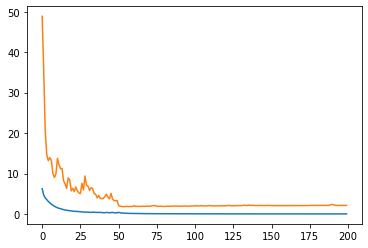

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [33]:
new_accuracy = [(x + y)/2 for x, y in zip(history.history['loc_accuracy'],history.history['conf_accuracy'])]

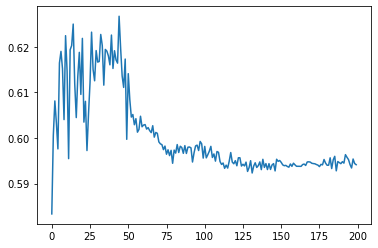

In [35]:


plt.plot(new_accuracy)
# plt.plot(history.history['val_loss'])

In [37]:
import shutil
shutil.make_archive('logs_200_epoch', 'zip', '/kaggle/working/Minor-Project-Monument-Detection/logs')

'/kaggle/working/Minor-Project-Monument-Detection/logs_200_epoch.zip'